
### dataset = Custom



## Loading the important libraries and Dataset

In [1]:
! nvidia-smi

Sun Oct 11 20:44:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 31%   49C    P0    88W / 250W |    259MiB / 11011MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   35C    P8     1W / 250W |      1MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, average_precision_score, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
#!pip install albumentations
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE, RandomRotate90, ShiftScaleRotate

In [5]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

### Loading the data and splitting it into training and validation set.

In [6]:
#########################
# USER Set

# Path Set

# Dataset_dir
dataset_name = 'CrackTree260'
dataset_dir = os.path.join('/data/crack', dataset_name)

test_image_dir = os.path.join(dataset_dir,'test','image')
test_mask_dir = os.path.join(dataset_dir,'test','mask')

# Loading model path

# modelSave_name = "concrete_cracks_{}.h5".format(dataset_name)
load_model_name = "concrete_cracks_{}.h5".format(dataset_name)
#load_model_name = "concrete_cracks_{}.h5".format('_')  # put the description of weight model.

model_path = os.path.join(dataset_dir, load_model_name)

results_DIR = os.path.join(dataset_dir, "results", dataset_name)
results_image_DIR = os.path.join(results_DIR, "image")
results_mask_DIR = os.path.join(results_DIR, "mask")
results_overlap_DIR = os.path.join(results_DIR, "overlap")

def checkDirExist(folder_dir):
    try:
        if not(os.path.isdir(folder_dir)):
            os.makedirs(os.path.join(folder_dir))
    except OSError as e:
        if e.errno != errno.EEXIST:
            print("Failed to crate directory!!!!")
            raise

checkDirExist(results_DIR)            
checkDirExist(results_image_DIR)       
checkDirExist(results_mask_DIR)       
checkDirExist(results_overlap_DIR)

# Process Setting
mode_run_type = ['train', 'test', 'inference']
mode_run = mode_run_type[0] # 0 is train, 1 is test, 2 is inference

set_test = True
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [7]:

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])
test_image_files = test_image_paths
test_mask_files = test_mask_paths
print("Number of testing images : ", len(test_image_paths))
print("Number of testing masks : ", len(test_mask_paths))
print('\n')

Number of testing images :  315
Number of testing masks :  315




In [8]:
batch_size = 10
img_dim=(256, 256)

# Generator to load and augment the image batch wise

In [9]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [                   
      Flip(p=0.7),
      Rotate(p=0.7),
      RandomRotate90(),
      ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=90, p=0.2),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3)
      #      ], p=0.3),
      #OneOf([
      #        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
      #        GridDistortion(),
      #        OpticalDistortion(distort_limit=2, shift_limit=0.5)
      #      ], p=0.3),
    ])

  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    file_names = []
    
    for file_path in batch_x:
        file_path = os.path.basename(file_path)
        file_names.append(file_path)
        
    #print(len(file_names))
    
    batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
    batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])
    

    #print(file_names)
        
    if self.augment is True:
        batch_xx = batch_x
        batch_yy = batch_y
        for ii in range(10-1):
            aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_xx, batch_yy)]
            batch_x = np.vstack([batch_x, np.array([i['image'] for i in aug])])
            batch_y = np.vstack([batch_y, np.array([j['mask'] for j in aug])])
            #batch_x = np.stack(batch_x, [i['image'] for i in aug], axis=0)
            #batch_y = np.stack(batch_x, [j['mask'] for j in aug], axis=0)
        
        batch_y = np.expand_dims(batch_y, -1)
    
    
    return batch_x/255, batch_y/1, file_names

In [10]:
def visualize(image_x, image_y):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(image_x)
    plt.show()
        
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(np.squeeze(image_y, -1), cmap='gray')
    plt.show()

# Model

In [11]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate
from keras.regularizers import l2

Using TensorFlow backend.


In [12]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [13]:
#conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [14]:
#Fixed layer.
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    
    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([conv, shortcut])
    return output

In [15]:
# Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)
    
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([shortcut, res])
    return output

In [16]:
# Upsampling Concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [17]:
# MODEL
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))
    
    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)
    
    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)
    
    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [18]:
K.clear_session()
model = ResUNet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

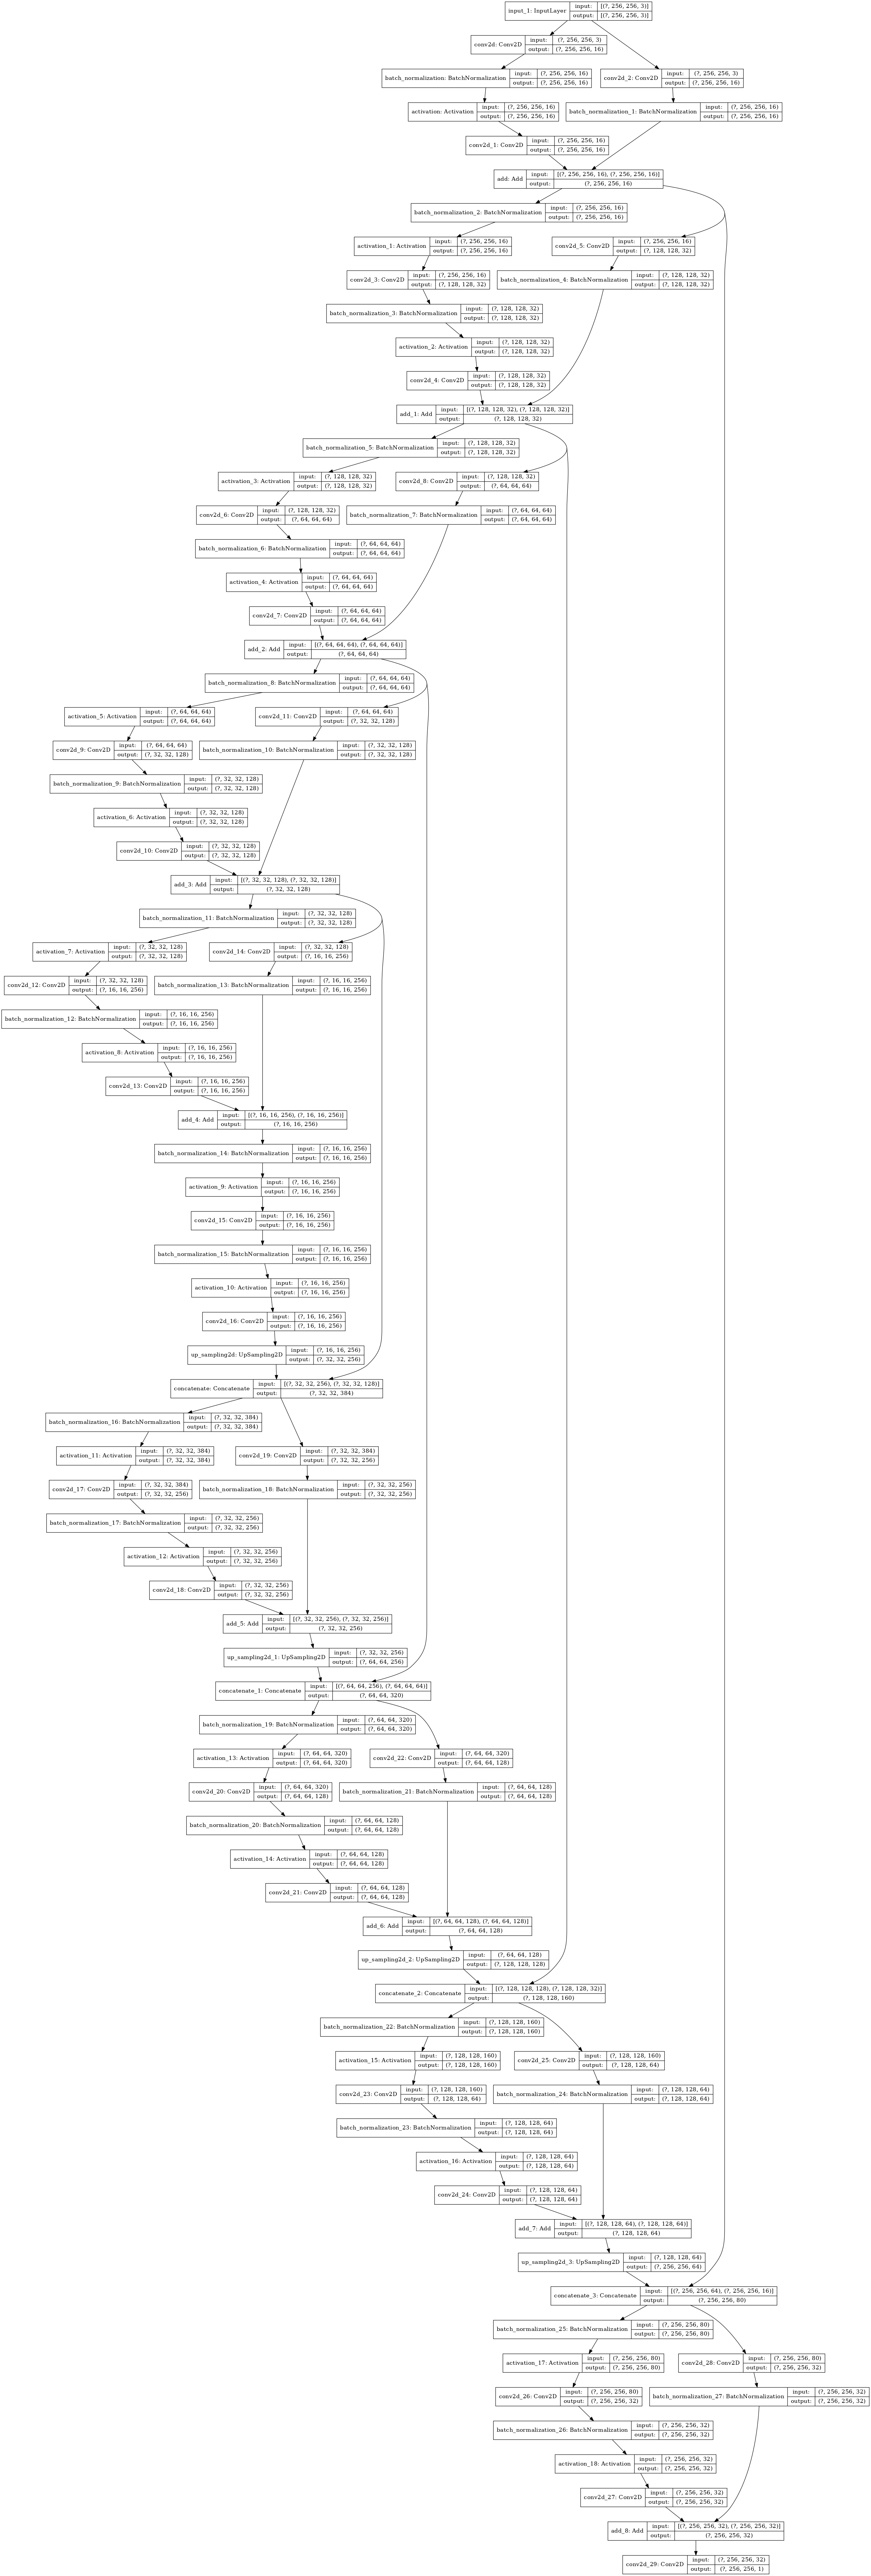

In [20]:
from tensorflow.keras.utils import  plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100,
)

# Loss
# &
# Compile

In [21]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou



In [22]:
def lr_schedule(epoch):

    lr =0.0035
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD


import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)

#from tensorflow.keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=4)


#from tensorflow.keras.utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=2, cpu_merge=True, cpu_relocation=False)

model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

## Testing

In [23]:
model.load_weights(model_path)

print("Loaded model from disk")

Loaded model from disk


In [24]:
import time
number_test_data  = len(test_image_files)
test_generator = Generator(test_image_files, test_mask_files, number_test_data, img_dim)

yy_test=[]
for x_test, y_test, file_path in test_generator:
    break
for ii in y_test:
    yy_test = cv2.dilate(y_test[ii], kernel, iterations=2)
    yy_test = np.vsta(yy_test)
    
y_test = 

start_time = time.time()
y_pred = model.predict(x_test)

t = time.time()

dt = (t-start_time)/number_test_data
print("time is {}".format(dt))
print("fps is {}".format(1/dt))
yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

315
time is 0.019349930778382315
fps is 51.67977143965791


In [25]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

AP = average_precision_score(y_test.flatten(), y_pred.flatten())

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("AP: {0:.4f}\n".format(AP))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9952

AP: 0.5039

Precision: 0.6339

Recall: 0.5513

F1-Score: 0.5897

Sensitivity: 0.5513

Specificity: 0.9980

AUC: 0.8403

IOU: 0.4182

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00  20515132
        True       0.63      0.55      0.59    128708

    accuracy                           1.00  20643840
   macro avg       0.82      0.77      0.79  20643840
weighted avg       0.99      1.00      1.00  20643840



[False  True]


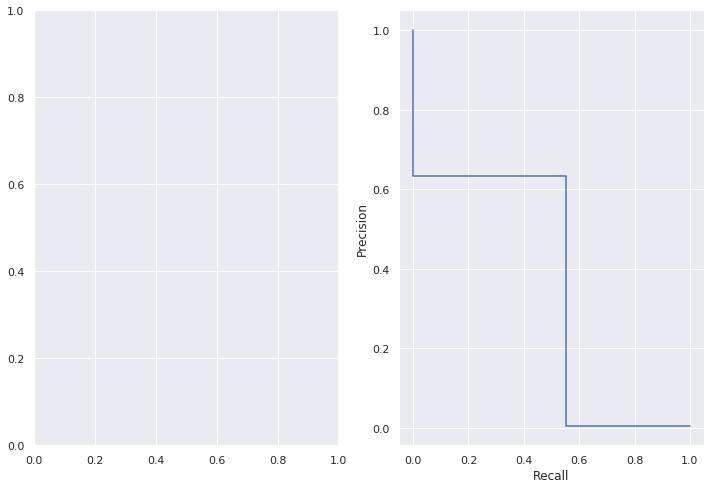

"\nfig, axes = plt.subplots(1, 2, figsize=(13,4))\naxes = axes.flatten()\n\naxes[0].plot(prec, label='training')\naxes[0].plot(recall, label='validation')\naxes[0].set_title('Accuracy Curve')\naxes[0].set_xlabel('epochs')\naxes[0].set_ylabel('accuracy')\naxes[0].legend()\n\n\naxes[1].plot(prec, label='training')\naxes[1].plot(recall, label='validation')\naxes[1].set_title('Loss Curve')\naxes[1].set_xlabel('epochs')\naxes[1].set_ylabel('loss')\naxes[1].legend()\n\n\nplt.show()\n"

In [40]:
prec, recall, thre = precision_recall_curve(yy_true, yy_pred )#sample_weight=np.arange(0,1,0.2))
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
print(thre)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 8))

#roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()
'''
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(prec, label='training')
axes[0].plot(recall, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(prec, label='training')
axes[1].plot(recall, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()


plt.show()
'''

In [27]:
import colorsys
import random

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:,:,c] = np.where(mask==1,
                               image[:,:,c] *
                               (1-alpha) + alpha * color[c] * 255,
                               image[:, :, c])
    return image

def save_image(image, masks, save_folder, image_name, class_names=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None, scores=None):
#def save_image(image, boxes, masks, class_ids, save_folder, image_name, class_names=None,
#                      show_mask=True, show_bbox=True,
#                      colors=None, captions=None, scores=None):
    # Number of instances
    N = masks.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert masks.shape[-1] 
    N = 1
    
    
    # Generate random colors
    colors = colors or random_colors(N)
    
    height, width = image.shape[:2]
    #masked_image = image.copy()#image.astype(np.uint32).copy()
    masked_image = np.copy(image) #image.astype(np.uint32)
    masked_image = np.array(masked_image)*float(255)
    print(masked_image)
    for i in range(N):
        color = colors[i]

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
    
    #display_images(masked_image, cols=1)
    #masked_image = np.astype(masked_image, dtype=np.uint8)
    #print(masked_image)
    #masked_image = masked_image.astype(np.float32)
    #cv2.rectangle(masked_image, (1,2),(3,4 ), color, 2)
    #print(masked_image.dtype)    

    result_image_path = os.path.join(save_folder, image_name)
    cv2.imwrite(result_image_path, masked_image)

test = zip(x_test, y_pred, file_path)
for ii, jj, kk in test:
    #save_image(x_test, y_pred, results_overlap_DIR, file_path)
    #print(ii)
    #print(jj)
    #print(kk)
    #ii=np.reshape(ii, (1,256,256,3))
    #jj=np.reshape(jj, (1,256,256,1))

    save_image(ii, jj, results_overlap_DIR, kk)
    cv2.imwrite(os.path.join(results_image_DIR,kk), np.array(ii)*float(255))
    cv2.imwrite(os.path.join(results_mask_DIR,kk), np.array(jj)*float(255))
                

[[[ 72.  72.  72.]
  [ 62.  62.  62.]
  [ 49.  49.  49.]
  ...
  [ 47.  47.  47.]
  [ 49.  49.  49.]
  [ 47.  47.  47.]]

 [[ 54.  54.  54.]
  [ 63.  63.  63.]
  [ 56.  56.  56.]
  ...
  [ 49.  49.  49.]
  [ 38.  38.  38.]
  [ 52.  52.  52.]]

 [[ 67.  67.  67.]
  [ 77.  77.  77.]
  [ 68.  68.  68.]
  ...
  [ 60.  60.  60.]
  [ 55.  55.  55.]
  [ 60.  60.  60.]]

 ...

 [[117. 117. 117.]
  [110. 110. 110.]
  [115. 115. 115.]
  ...
  [116. 116. 116.]
  [144. 144. 144.]
  [124. 124. 124.]]

 [[121. 121. 121.]
  [132. 132. 132.]
  [135. 135. 135.]
  ...
  [109. 109. 109.]
  [103. 103. 103.]
  [103. 103. 103.]]

 [[116. 116. 116.]
  [120. 120. 120.]
  [108. 108. 108.]
  ...
  [125. 125. 125.]
  [120. 120. 120.]
  [130. 130. 130.]]]
[[[ 98.  98.  98.]
  [ 97.  97.  97.]
  [104. 104. 104.]
  ...
  [152. 152. 152.]
  [119. 119. 119.]
  [102. 102. 102.]]

 [[ 99.  99.  99.]
  [101. 101. 101.]
  [ 97.  97.  97.]
  ...
  [154. 154. 154.]
  [119. 119. 119.]
  [113. 113. 113.]]

 [[ 97.  97.  97.]

[[[108. 108. 108.]
  [ 96.  96.  96.]
  [ 93.  93.  93.]
  ...
  [113. 113. 113.]
  [145. 145. 145.]
  [136. 136. 136.]]

 [[ 87.  87.  87.]
  [ 99.  99.  99.]
  [106. 106. 106.]
  ...
  [117. 117. 117.]
  [178. 178. 178.]
  [151. 151. 151.]]

 [[ 97.  97.  97.]
  [101. 101. 101.]
  [ 91.  91.  91.]
  ...
  [125. 125. 125.]
  [184. 184. 184.]
  [141. 141. 141.]]

 ...

 [[ 90.  90.  90.]
  [ 93.  93.  93.]
  [ 99.  99.  99.]
  ...
  [110. 110. 110.]
  [119. 119. 119.]
  [117. 117. 117.]]

 [[ 97.  97.  97.]
  [ 97.  97.  97.]
  [ 99.  99.  99.]
  ...
  [105. 105. 105.]
  [114. 114. 114.]
  [111. 111. 111.]]

 [[ 92.  92.  92.]
  [ 95.  95.  95.]
  [ 87.  87.  87.]
  ...
  [109. 109. 109.]
  [108. 108. 108.]
  [109. 109. 109.]]]
[[[113. 113. 113.]
  [124. 124. 124.]
  [107. 107. 107.]
  ...
  [ 94.  94.  94.]
  [ 96.  96.  96.]
  [ 82.  82.  82.]]

 [[145. 145. 145.]
  [148. 148. 148.]
  [117. 117. 117.]
  ...
  [ 82.  82.  82.]
  [ 86.  86.  86.]
  [105. 105. 105.]]

 [[166. 166. 166.]

[[[151. 151. 151.]
  [162. 162. 162.]
  [141. 141. 141.]
  ...
  [ 96.  96.  96.]
  [115. 115. 115.]
  [103. 103. 103.]]

 [[143. 143. 143.]
  [179. 179. 179.]
  [172. 172. 172.]
  ...
  [110. 110. 110.]
  [123. 123. 123.]
  [103. 103. 103.]]

 [[135. 135. 135.]
  [151. 151. 151.]
  [168. 168. 168.]
  ...
  [122. 122. 122.]
  [127. 127. 127.]
  [109. 109. 109.]]

 ...

 [[112. 112. 112.]
  [110. 110. 110.]
  [119. 119. 119.]
  ...
  [ 96.  96.  96.]
  [ 99.  99.  99.]
  [ 99.  99.  99.]]

 [[125. 125. 125.]
  [124. 124. 124.]
  [131. 131. 131.]
  ...
  [ 94.  94.  94.]
  [ 96.  96.  96.]
  [ 95.  95.  95.]]

 [[132. 132. 132.]
  [138. 138. 138.]
  [134. 134. 134.]
  ...
  [ 91.  91.  91.]
  [ 96.  96.  96.]
  [ 94.  94.  94.]]]
[[[143. 143. 143.]
  [155. 155. 155.]
  [148. 148. 148.]
  ...
  [135. 135. 135.]
  [126. 126. 126.]
  [133. 133. 133.]]

 [[149. 149. 149.]
  [154. 154. 154.]
  [145. 145. 145.]
  ...
  [132. 132. 132.]
  [148. 148. 148.]
  [201. 201. 201.]]

 [[134. 134. 134.]

[[[ 75.  75.  75.]
  [ 89.  89.  89.]
  [106. 106. 106.]
  ...
  [ 92.  92.  92.]
  [116. 116. 116.]
  [103. 103. 103.]]

 [[ 76.  76.  76.]
  [ 89.  89.  89.]
  [ 75.  75.  75.]
  ...
  [ 86.  86.  86.]
  [114. 114. 114.]
  [107. 107. 107.]]

 [[ 70.  70.  70.]
  [ 94.  94.  94.]
  [ 61.  61.  61.]
  ...
  [109. 109. 109.]
  [133. 133. 133.]
  [ 81.  81.  81.]]

 ...

 [[115. 115. 115.]
  [ 67.  67.  67.]
  [ 98.  98.  98.]
  ...
  [ 83.  83.  83.]
  [123. 123. 123.]
  [101. 101. 101.]]

 [[ 96.  96.  96.]
  [ 67.  67.  67.]
  [ 91.  91.  91.]
  ...
  [ 89.  89.  89.]
  [ 99.  99.  99.]
  [117. 117. 117.]]

 [[ 62.  62.  62.]
  [ 61.  61.  61.]
  [ 54.  54.  54.]
  ...
  [ 81.  81.  81.]
  [ 93.  93.  93.]
  [ 87.  87.  87.]]]
[[[ 77.  77.  77.]
  [111. 111. 111.]
  [ 89.  89.  89.]
  ...
  [ 97.  97.  97.]
  [110. 110. 110.]
  [ 82.  82.  82.]]

 [[ 66.  66.  66.]
  [ 98.  98.  98.]
  [ 82.  82.  82.]
  ...
  [ 78.  78.  78.]
  [ 86.  86.  86.]
  [ 86.  86.  86.]]

 [[ 71.  71.  71.]

[[[101. 101. 101.]
  [ 94.  94.  94.]
  [ 98.  98.  98.]
  ...
  [ 83.  83.  83.]
  [ 83.  83.  83.]
  [ 78.  78.  78.]]

 [[108. 108. 108.]
  [ 98.  98.  98.]
  [ 91.  91.  91.]
  ...
  [ 87.  87.  87.]
  [ 92.  92.  92.]
  [ 78.  78.  78.]]

 [[ 93.  93.  93.]
  [103. 103. 103.]
  [113. 113. 113.]
  ...
  [ 76.  76.  76.]
  [106. 106. 106.]
  [127. 127. 127.]]

 ...

 [[101. 101. 101.]
  [ 95.  95.  95.]
  [ 88.  88.  88.]
  ...
  [ 87.  87.  87.]
  [ 85.  85.  85.]
  [112. 112. 112.]]

 [[104. 104. 104.]
  [ 98.  98.  98.]
  [117. 117. 117.]
  ...
  [ 75.  75.  75.]
  [ 82.  82.  82.]
  [ 98.  98.  98.]]

 [[147. 147. 147.]
  [101. 101. 101.]
  [108. 108. 108.]
  ...
  [ 74.  74.  74.]
  [114. 114. 114.]
  [129. 129. 129.]]]
[[[100. 100. 100.]
  [ 75.  75.  75.]
  [ 97.  97.  97.]
  ...
  [ 68.  68.  68.]
  [ 67.  67.  67.]
  [ 75.  75.  75.]]

 [[122. 122. 122.]
  [ 88.  88.  88.]
  [114. 114. 114.]
  ...
  [ 62.  62.  62.]
  [ 67.  67.  67.]
  [ 71.  71.  71.]]

 [[109. 109. 109.]

[[[ 80.  80.  80.]
  [ 68.  68.  68.]
  [ 70.  70.  70.]
  ...
  [ 85.  85.  85.]
  [ 66.  66.  66.]
  [ 84.  84.  84.]]

 [[ 95.  95.  95.]
  [ 61.  61.  61.]
  [ 66.  66.  66.]
  ...
  [ 60.  60.  60.]
  [ 52.  52.  52.]
  [ 83.  83.  83.]]

 [[ 92.  92.  92.]
  [ 77.  77.  77.]
  [ 71.  71.  71.]
  ...
  [ 60.  60.  60.]
  [ 58.  58.  58.]
  [ 63.  63.  63.]]

 ...

 [[ 58.  58.  58.]
  [ 83.  83.  83.]
  [ 85.  85.  85.]
  ...
  [ 63.  63.  63.]
  [ 97.  97.  97.]
  [110. 110. 110.]]

 [[ 64.  64.  64.]
  [ 73.  73.  73.]
  [ 72.  72.  72.]
  ...
  [ 57.  57.  57.]
  [ 60.  60.  60.]
  [ 78.  78.  78.]]

 [[ 71.  71.  71.]
  [ 81.  81.  81.]
  [ 83.  83.  83.]
  ...
  [ 54.  54.  54.]
  [ 54.  54.  54.]
  [ 61.  61.  61.]]]
[[[ 73.  73.  73.]
  [ 64.  64.  64.]
  [ 80.  80.  80.]
  ...
  [ 65.  65.  65.]
  [ 57.  57.  57.]
  [ 65.  65.  65.]]

 [[ 66.  66.  66.]
  [ 51.  51.  51.]
  [108. 108. 108.]
  ...
  [ 70.  70.  70.]
  [ 54.  54.  54.]
  [ 51.  51.  51.]]

 [[ 63.  63.  63.]

[[[ 82.  82.  82.]
  [132. 132. 132.]
  [112. 112. 112.]
  ...
  [154. 154. 154.]
  [197. 197. 197.]
  [224. 224. 224.]]

 [[ 94.  94.  94.]
  [ 91.  91.  91.]
  [ 90.  90.  90.]
  ...
  [140. 140. 140.]
  [165. 165. 165.]
  [173. 173. 173.]]

 [[ 86.  86.  86.]
  [ 77.  77.  77.]
  [ 99.  99.  99.]
  ...
  [136. 136. 136.]
  [131. 131. 131.]
  [179. 179. 179.]]

 ...

 [[ 96.  96.  96.]
  [ 99.  99.  99.]
  [111. 111. 111.]
  ...
  [136. 136. 136.]
  [149. 149. 149.]
  [173. 173. 173.]]

 [[ 98.  98.  98.]
  [ 97.  97.  97.]
  [109. 109. 109.]
  ...
  [136. 136. 136.]
  [137. 137. 137.]
  [137. 137. 137.]]

 [[105. 105. 105.]
  [ 98.  98.  98.]
  [ 98.  98.  98.]
  ...
  [171. 171. 171.]
  [196. 196. 196.]
  [175. 175. 175.]]]
[[[ 94.  94.  94.]
  [ 89.  89.  89.]
  [ 93.  93.  93.]
  ...
  [152. 152. 152.]
  [191. 191. 191.]
  [211. 211. 211.]]

 [[102. 102. 102.]
  [ 86.  86.  86.]
  [ 79.  79.  79.]
  ...
  [153. 153. 153.]
  [159. 159. 159.]
  [185. 185. 185.]]

 [[ 90.  90.  90.]

In [28]:
'''
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
            
        y1, x1, y2, x2 = boxes[i]
        print(x1, y1, x2, y2)
        
        colorInt = np.array(list(color), dtype=np.int32)
        
        if show_bbox:
            p = cv2.rectangle(masked_image, (10, 10), (50, 50), (255,0,0), 2)
                #patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                #                alpha=0.7, linestyle="dashed",
                #                edgecolor=color, facecolor='none')
            #ax.add_patch(p)

        # Label
#        if not captions:
#            class_id = class_ids[i]
#            score = scores[i] if scores is not None else None
#            label = class_names[class_id]
#            caption = "{} {:.3f}".format(label, score) if score else label
#        else:
#            caption = captions[i]
#        ax.text(x1, y1 + 8, caption,
#                color='w', size=11, backgroundcolor="none")
'''

'''
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            #(mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
'''     

'\n        # Mask Polygon\n        # Pad to ensure proper polygons for masks that touch image edges.\n        padded_mask = np.zeros(\n            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)\n            #(mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)\n        padded_mask[1:-1, 1:-1] = mask\n        contours = find_contours(padded_mask, 0.5)\n'